# Introduction to Timeseries datasets

> Note: you will be best served by familiarizing yourself with the more basic notebooks _Introduction to Argovis_ and _Intro to Argovis' Grid API_ before following this notebook.

The generic point schema used by Argovis for point-like data such as Argo profiles and grids works well for data that can be feasilby captured as documents with unique latitude, longitude, and timestamps. However, when considering higher-resolution datasets, indexing independent documents for each such coordinate triple can dramatically exceed the scale of computing resources the point data above requires; for example, while Argo has roughly 3 million such profile documents to consider at the time of writing, a global, quarter-degree grid measured daily for 30 years (a typical scale for satellite products) would have on the order of *10 billion* such documents. In order to represent, index and serve such high-resolution grids on similar compute infrastructure to the point data, we make a minor modification to the generic point schema to form the *generic timeseries schema*:

 - Vectors in the ``data`` object represent surface measurements, estimates or flags as an ordered timeseries.
 - The ``data`` document no longer has a single ``timestamp`` key, as the data within corresponds to many timestamps.
 - The ``metadata`` or ``data`` document must bear a ``timeseries`` key, which is an ordered list of timestamps corresponding to the times associated with each element in the ``data`` vectors.

The observant reader will notice that this is very similar to the gridded products which have a ``levels`` key indicating the model depths for each entry in their ``data`` vectors. All other aspects of the generic schema remain consistent between point and timeseries datasets. In this notebook, we'll illustrate the unique features of a couple of timeseries datasets; for all other details, the reader is encouraged to apply what they learned from other Argovis API examples, as most query filters and behaviors remain identical between point and timeseries datasets.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for API_KEY in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [10]:
from argovisHelpers import helpers as avh

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt # e.g. to change the size of figures created from functions

from Argovis_tasks_helpers import get_route,list_values_for_parameter_to_api_query,show_variable_names_for_collections
from Argovis_tasks_helpers import get_api_output_formatted_list_1var_for_regions_and_timeranges
from Argovis_tasks_helpers import api_output_formatted_list_1var_plot_map

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

In [2]:
# for a list of collections, please see the Argovis swagger page

#### in the following we set parameters to plot different gridded products
selection_params = {}
#+++ example to use Argo profile data and the glodap gridded product (which provides time mean fields)
selection_params['collections']  = ['timeseries/noaasst',
                                    'timeseries/copernicussla',
                                   'timeseries/ccmpwind',
                                   'grids/rg09',
                                   'grids/glodap',
                                   'grids/kg21']
selection_params['collections']  = ['grids/rg09',
                                   'grids/glodap',
                                   'grids/kg21']
#+++


In [3]:
# for each selected collection, we list the variables that are available
vars_lists = show_variable_names_for_collections(collections_list=selection_params['collections'],API_KEY=API_KEY,verbose=True)


https://argovis-api.colorado.edu/grids/rg09/vocabulary?parameter=data
>>>>> grids/rg09
['rg09_salinity', 'rg09_temperature']
https://argovis-api.colorado.edu/grids/glodap/vocabulary?parameter=data
>>>>> grids/glodap
['Cant', 'Cant_Input_N', 'Cant_Input_mean', 'Cant_Input_std', 'Cant_error', 'Cant_relerr', 'NO3', 'NO3_Input_N', 'NO3_Input_mean', 'NO3_Input_std', 'NO3_error', 'NO3_relerr', 'OmegaA', 'OmegaA_Input_N', 'OmegaA_Input_mean', 'OmegaA_Input_std', 'OmegaA_error', 'OmegaA_relerr', 'OmegaC', 'OmegaC_Input_N', 'OmegaC_Input_mean', 'OmegaC_Input_std', 'OmegaC_error', 'OmegaC_relerr', 'PI_TCO2', 'PI_TCO2_Input_N', 'PI_TCO2_Input_mean', 'PI_TCO2_Input_std', 'PI_TCO2_error', 'PI_TCO2_relerr', 'PO4', 'PO4_Input_N', 'PO4_Input_mean', 'PO4_Input_std', 'PO4_error', 'PO4_relerr', 'TAlk', 'TAlk_Input_N', 'TAlk_Input_mean', 'TAlk_Input_std', 'TAlk_error', 'TAlk_relerr', 'TCO2', 'TCO2_Input_N', 'TCO2_Input_mean', 'TCO2_Input_std', 'TCO2_error', 'TCO2_relerr', 'oxygen', 'oxygen_Input_N', 'oxyg

In [22]:
# indicate the variable of interest for each collection
selection_params['varnames']     = ['rg09_temperature', 'temperature', 'kg21_ohc15to300']
# let's indicate if we would like to store extra variables in addition to the ones above: 
# points will be returned only if they have (for that collection) the variable indicated
# above AND any variable indicated in data_extra (i.e. for gridded products this is not
# a real constraint as all the variables that are available, are available at all the 
# locations on the grid
selection_params['data_extra']   = ['',',oxygen','']

In [23]:
for i,ilist in enumerate(vars_lists):
    if selection_params['varnames'][i] not in ilist:
        print('>>>>> '+selection_params['collections'][i]+' does not include selected variable, i.e. '+selection_params['varnames'][i])
        print('Here is a list of the variables that are included:')
        print(ilist)
        change_name_of_selected_variable_before_continuing
    else:
        print('>>>>> '+selection_params['collections'][i]+' includes selected variable, i.e. '+selection_params['varnames'][i])

>>>>> grids/rg09 includes selected variable, i.e. rg09_temperature
>>>>> grids/glodap includes selected variable, i.e. temperature
>>>>> grids/kg21 includes selected variable, i.e. kg21_ohc15to300


In [24]:
# for each collection, we show the time period of interest
# (please note that this code will be updated in the near future to leverage upcoming summary documemnts for each collection; at that point, the information of interest will be accessed in the same way for all the collections)
for icollection in selection_params['collections']:
    metaQuery = {'id': icollection.split('/')[1]}
    print('--> '+icollection)
    meta = avh.query(icollection.split('/')[0]+'/meta', options=metaQuery, apikey=API_KEY, apiroot=get_route(icollection),verbose=True)
    
    try:
        for imeta in meta:
            if 'timeseries' in imeta.keys():
                print('Time period available:')
                print(imeta['timeseries'][0])
                print(imeta['timeseries'][-1])
    except:
        options = {'box': [[-60,27],[-59, 28]]}
        bfr     = avh.query(icollection, options=options, apikey=API_KEY, apiroot=get_route(icollection),verbose=False)
        bfr_time= [x['timestamp'] for x in bfr]
        print('Time period available:')
        print(min(bfr_time))
        print(max(bfr_time))
        

--> grids/rg09
https://argovis-api.colorado.edu/grids/meta?id=rg09
Time period available:
2004-01-15T00:00:00.000Z
2022-05-15T00:00:00.000Z
--> grids/glodap
https://argovis-api.colorado.edu/grids/meta?id=glodap
--> grids/kg21
https://argovis-api.colorado.edu/grids/meta?id=kg21
Time period available:
2005-01-15T00:00:00.000Z
2020-12-15T00:00:00.000Z


In [25]:
#### params varying with the region

# in this example, we will use the 'box' selection type (i.e. we query the data within boxes),
# hence we indicate here the bottom/left and top/right vertices for each box of interest... 
# the other option is to search in a 'polygon' and indicate the polygon
# vertices in a list (first and last vertex should be the same)
selection_params['regions']     = [
                        [[-55.5,35.5],[-45.5,40.5]],
                        ]
selection_params['regions_type'] = ['box', 'box']

selection_params['regions_tag'] = ['Atlantic','Pacific',]
####

In [26]:
# list of startDate and endDates of interest (note: these will not be used for glodap as glodap only provides a time mean)
selection_params['startDate']    = ['2018-01-10T00:00:00Z']
selection_params['endDate']      = ['2018-01-17T00:00:00Z']

# colors to use for the line plots
colors = list(mcolors.TABLEAU_COLORS.keys())

In [27]:
# let's retrieve the data of interest
api_output_formatted_list = get_api_output_formatted_list_1var_for_regions_and_timeranges(selection_params=selection_params,API_KEY=API_KEY)
ciao


>>>>>>>>> grids/rg09 rg09_temperature, Atlantic 2018-01-10 to 2018-01-17
https://argovis-api.colorado.edu/grids/rg09?data=rg09_temperature&box=[[-55.5,+35.5],+[-45.5,+40.5]]&startDate=2018-01-10T00:00:00.000000Z&endDate=2018-01-17T00:00:00.000000Z
https://argovis-api.colorado.edu/grids/meta?id=rg09_temperature_200401_Total
https://argovis-api.colorado.edu/grids/meta?id=rg09_salinity_200401_Total
>>>>>>>>> grids/glodap temperature, Atlantic 2018-01-10 to 2018-01-17
https://argovis-api.colorado.edu/grids/glodap?data=temperature,oxygen&box=[[-55.5,+35.5],+[-45.5,+40.5]]&startDate=1000-01-01T00:00:00.000000Z&endDate=1000-01-02T00:00:00.000000Z
https://argovis-api.colorado.edu/grids/meta?id=glodapv2.2016b
https://argovis-api.colorado.edu/grids/meta?id=glodapv2.2016b
>>>>>>>>> grids/kg21 kg21_ohc15to300, Atlantic 2018-01-10 to 2018-01-17
https://argovis-api.colorado.edu/grids/kg21?data=kg21_ohc15to300&box=[[-55.5,+35.5],+[-45.5,+40.5]]&startDate=2018-01-10T00:00:00.000000Z&endDate=2018-01-17

NameError: name 'ciao' is not defined

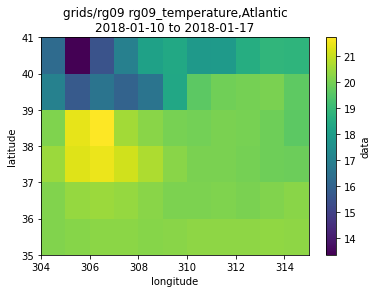

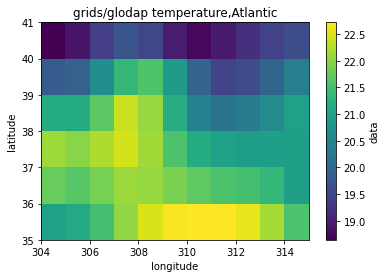

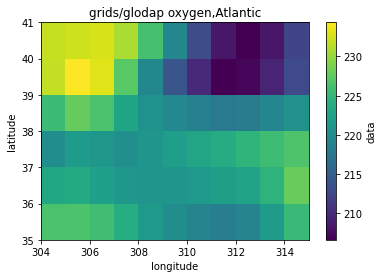

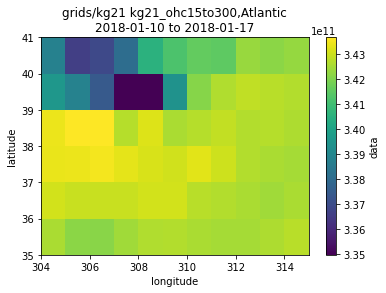

In [28]:
api_output_formatted_list_1var_plot_map(api_output_formatted_list,ilev=0,itime=0)  


In [29]:
api_output_formatted_list

[{'rg09_temperature': {'collection': 'grids/rg09',
   'varname': 'rg09_temperature',
   'data_units': 'degree celcius (ITS-90)',
   'data_xarray': <xarray.Dataset>
   Dimensions:    (latitude: 6, longitude: 11, levels: 58, timestamp: 1)
   Coordinates:
     * latitude   (latitude) float64 35.5 36.5 37.5 38.5 39.5 40.5
     * longitude  (longitude) float64 304.5 305.5 306.5 307.5 ... 312.5 313.5 314.5
     * levels     (levels) float64 2.5 10.0 20.0 30.0 ... 1.8e+03 1.9e+03 1.975e+03
     * timestamp  (timestamp) object '2018-01-15T00:00:00.000Z'
   Data variables:
       data       (latitude, longitude, levels, timestamp) float64 20.14 ... 3.826,
   'region': [[-55.5, 35.5], [-45.5, 40.5]],
   'startDate': '2018-01-10T00:00:00Z',
   'endDate': '2018-01-17T00:00:00Z',
   'region_type': 'box',
   'region_tag': 'Atlantic',
   'varname_title': 'Rg09_temperature'}},
 {'temperature': {'collection': 'grids/glodap',
   'varname': 'temperature',
   'data_units': 'degrees celcius',
   'data_xarr

# NOAA Sea surface temperature timeseries

Argovis indexes the weekly average sea surface temperature on a 1 degree grid as provided by NOAA via [https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html). Let's start by having a look at the metadata for this collection:

In [ ]:
sstMetaQuery = {
    'id': 'noaasst' 
}

sstMeta = avh.query('timeseries/meta', options=sstMetaQuery, apikey=API_KEY, apiroot=API_ROOT,verbose=True)
print(sstMeta)

We can see from the usual `data_info` that this dataset contains one variable called `sst` corresponding to weekly mean sea surface temperature. A feature unique to timeseries datasets is that the metadata document (of which there is one per dataset) contains a `timeseries` key; this lists all the timesteps for all the timeseries in the dataset.

Additionally, all metadata documents for data products interpolated to a longitude/latitude grid also include a `lattice` key that describes the structure of the grid in latitude and longitude.

> **What does lattice center and spacing mean?** Each product with a regular grid indexed by argovis describes its grid with a centerpoint, which is an arbitrary point on the grid close to [0,0] denoted as [longitude, latitude]. Other grid points are found stepping along by the amount in `lattice.spacing`, denoted as [longitude step, latitude step].

We can also have a look at a corresponding data document, ID'ed as `<longitude>_<latitude>`:

In [ ]:
sstQuery = {
    'id': '14.5_39.5',
    'data': 'sst'
}

sst = avh.query('timeseries/noaasst', options=sstQuery, apikey=API_KEY, apiroot=API_ROOT)
print(sst)

The `data` key here is structured according to `data_info` like all other Argovis datasets; the elements correspond to the timestamps in order as found on the metadata document. Asides from looking at `data_info`, the same vocabulary routes seen in other Argovis data products also exist for timeseries. As always, use `enum` to see the options, and then drill into any one of them individually like so:

In [ ]:
vocab = {
    'parameter': 'enum'
}

avh.query('timeseries/noaasst/vocabulary', options=vocab, apikey=API_KEY, apiroot=API_ROOT)

In [ ]:
vocab = {
    'parameter': 'data'
}

avh.query('timeseries/noaasst/vocabulary', options=vocab, apikey=API_KEY, apiroot=API_ROOT)

Going back to our data query, if instead we provide a time range:

In [ ]:
sstQuery = {
    'id': '14.5_39.5',
    'data': 'sst',
    'startDate': '1993-01-01T00:00:00Z',
    'endDate': '1993-02-01T00:00:00Z'
}

sst = avh.query('timeseries/noaasst', options=sstQuery, apikey=API_KEY, apiroot=API_ROOT)
print(sst)

we get a `timeseries` key appended to the data document to indicate the timestamps of the filtered timeseries; note this is in close analogy to how levels are filtered in Argovis' representation of Argo grids, for example.

## Zonal and meridional area-weighted averages for timeseries data

Much like gridded data, timeseries data can be arranged to easily compute zonal and meridional averages, with area weighting. Lets start by downloading a year of data for a region in the North Atlantic:

In [ ]:
sstQuery = {
  "startDate": '2002-01-01T00:00:00Z',
  "endDate": '2012-01-01T00:00:00Z',
  "polygon": [[-50,50],[-50,55],[-45,55],[-45,50],[-50,50]],
  "data": 'sst'
}
sst = avh.query('timeseries/noaasst', options=sstQuery, apikey=API_KEY, apiroot=API_ROOT)

> **Temporospatial limits of timeseries queries**: because timeseries documents contain information for every timestep in the series, we currently support queries on only small geographic areas, about 50 square degrees at the equator. However, long time duration queries like the one above are well supported. You can, of course, tile multipl requests to cover an arbitrary region.

If we then arrange these data documents into a dataframe with columns for longitude, latitude, timestamp and measurement, we can compute and plot area-weighted meridional and zonal averages with our helpers:

In [ ]:
df = helpers.level_df(sst, 
                      ['sst', 'longitude', 'latitude'], 
                      timesteps=sst[0]['timeseries'], 
                      index=["latitude","longitude","timestamp"]
                     )
ds = df.to_xarray()

In [ ]:
sst_mer = helpers.regional_mean(ds, form='meridional')
sst_mer['sst'].plot(y="timestamp")

In [ ]:
sst_zon = helpers.regional_mean(ds, form='zonal')
sst_zon['sst'].plot(y="timestamp")

# Copernicus sea level anomaly timeseries

Argovis indexes a quarter-degree grid of sea level anomalies and absolute dynamic topologies from [https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global); note that the original daily data reported at this link has been averaged down to weekly averages with timestamps aligned with the NOAA SST dataset described above, for scale and comparison purposes.

Let's again start by looking at the single metadata document for this collection:

In [ ]:
slaMetaQuery = {
    'id': 'copernicussla' 
}

slaMeta = avh.query('timeseries/meta', options=slaMetaQuery, apikey=API_KEY, apiroot=API_ROOT)
print(slaMeta)

Identical in structure to the SST metadata, though this dataset contains two data variables: the sea height anomaly `sla` as compared to the local average sea height over the reference period 1993-2012, and the absolute sea height including this anomaly, `adt`. We can query this dataset much the same as any other timeseries data:

In [ ]:
slaQuery = {
    'id': '-46.875_35.625',
    'data': 'all',
    'startDate': '1993-01-01T00:00:00Z',
    'endDate': '1993-02-01T00:00:00Z'
}

sla = avh.query('timeseries/copernicussla', options=slaQuery, apikey=API_KEY, apiroot=API_ROOT)
print(sla)

Here's an example of making an xarray dataset out of SLA data, similar to the SST example above:

In [ ]:
slaQuery_reg = {
  "startDate": '2002-01-01T00:00:00Z',
  "endDate": '2012-01-01T00:00:00Z',
  "polygon": [[-50,50],[-50,55],[-45,55],[-45,50],[-50,50]],
  "data": 'sla'
}

sla_reg = avh.query('timeseries/copernicussla', options=slaQuery_reg, apikey=API_KEY, apiroot=API_ROOT)

In [ ]:
df_sla = helpers.level_df(sla_reg, 
                      ['sla', 'longitude', 'latitude'], 
                      timesteps=sla_reg[0]['timeseries'], 
                      index=["latitude","longitude","timestamp"]
                     )
ds_sla = df_sla.to_xarray()

In [ ]:
ds_sla

In [ ]:
ds_sla['sla'][:,:,0].plot()

# REMSS CCMP wind vector product

Similarly to the sea level anaomaly time series, Argovis indexes a weekly average of the [REMSS CCMP wind vector product](https://www.remss.com/measurements/ccmp/). Have a look at the metadata:

In [ ]:
ccmpMetaQuery = {
    'id': 'ccmpwind' 
}

ccmpMeta = avh.query('timeseries/meta', options=ccmpMetaQuery, apikey=API_KEY, apiroot=API_ROOT)
print(ccmpMeta)

Let's find the wind data for the same location and time period as the sea surface heights above:

In [ ]:
ccmpQuery = {
    'id': '-46.875_35.625',
    'data': 'all',
    'startDate': '1993-01-01T00:00:00Z',
    'endDate': '1993-02-01T00:00:00Z'
}

ccmp = avh.query('timeseries/ccmpwind', options=ccmpQuery, apikey=API_KEY, apiroot=API_ROOT)
print(ccmp)

We can plot wind speeds in a region and on a date:

In [ ]:
params = {
  'startDate': '1993-01-01T00:00:00Z',
  'endDate': '1993-02-01T00:00:00Z',
  "polygon": [[-50,50],[-50,55],[-45,55],[-45,50],[-50,50]],
  "data": 'all'
}

wsdata = avh.query('timeseries/ccmpwind', options=params, apikey=API_KEY, apiroot=API_ROOT)

In [ ]:
df = helpers.level_df(wsdata, ['ws', 'longitude', 'latitude'], timesteps=wsdata[0]['timeseries'], index=['longitude', 'latitude', 'timestamp'])
ds = df.to_xarray()

In [ ]:
gridmap = ds.loc[{"timestamp":avh.parsetime('1993-01-10T00:00:00.000Z')}]
gridmap['ws'].plot()